1독 후 Iris 적용해보기

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [4]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
28*28

784

**Observe:**
* 이미지는 70,000개이고, 각 이미지가 28X28 픽셀이기 때문에 784개의 특성이 있다.
* 각 특성은 단순히 0(흰색) 부터 255(검정색)까지의 픽셀 강도를 나타낸다.

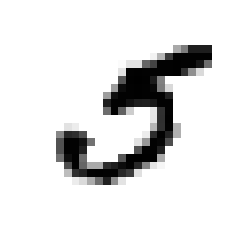

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
y[36000]

5.0

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

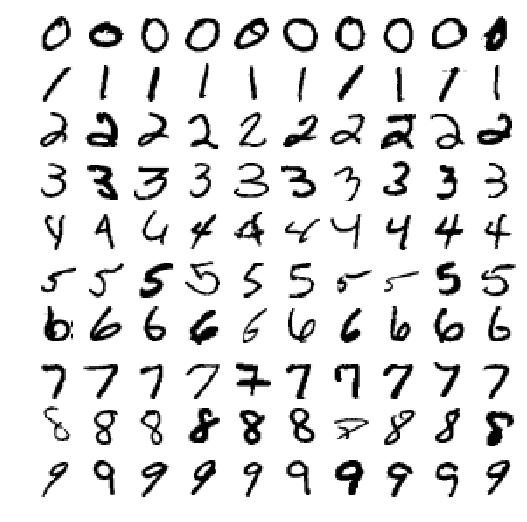

In [9]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 3.2 Binary Classifier

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=11)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=11, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([False])

## 3.3 성능측정

### 3.3.1 교차검증을 사용한 정확도 측정

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9626 , 0.9608 , 0.95185])

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9626
0.9608
0.95185


In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91095, 0.90745, 0.91055])

정확도가 90% 이상으로 나왔는데, 그것은 10%만 숫자 5이기 때문이다.  
무조건 5가 아님만 예측해도 90%를 맞출 수 있다.

**Note:**
* Accuracy(정확도)를 Classifier의 성능측정지표로 선호하지 않는 이유는  
  불균형한 데이터셋을 다룰 때, 크게 효용이 없다

### 3.3.2 오차행렬 (Confusion matrix)

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53664,   915],
       [ 1580,  3841]])

In [21]:
y_train_perfect_predictions = y_train_5

In [22]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Confusion Matrix**  

|             |예측 Positive  | 예측 Negative |
|:-----------:|:------------:|:------------:|
|**실제 Positive** |True Positive (TP)| False Negative (FN)|
|**실제 Negative** |False Positive (FP)| True Negative (TN)|

* Positive와 Negative의 위치는 바뀔 수 있다.  
  단, Raw와 Column이 함께 바껴야 한다. (실제 Negative Raw가 위로 간다면, 예측 Negative Column이 앞으로 가야 한다.)
* 가운데 4칸은 세로방향으로 예측 클래스와 같이 간다.  
* 대각성분은 정확하게 예측한 값

### 3.3 정밀도와 재현율

**Precision(정밀도)**  
$\quad$ : 예측입장에서 본 성능  
$\qquad$ 예) 예측한 사기거래 중에 정말 사기거래였던 비율
  
$\qquad$정밀도 = $\frac{TP}{TP+FP}$
  
  * 정밀도가 높다고 다 좋은 것은 아니다.  
    정밀도가 높다는 것은 분류기가 본인이 확실하다고 생각하는 것만 예측할 수 있다.  
    본인이 불확실한 다른 실제 양성 샘플을 그냥 무시할 수 있다.
  
**Recall(재현율)**  
$\quad$: 실제입장에서 본 성능  
$\qquad$예) 실제 사기거래를 사기거래라고 예측

$\qquad$ 재현율 = $\frac{TP}{TP+FN}$


정밀도와 재현율을 동시에 봐야 한다. 둘 사이에는 트레이드 오프 관계가 있다.
-------------------------
상황에 따라 정밀도가 중요할 때와 재현율이 중요할 때가 다르다.
-------------------------

예) 10개의 Ball 중에 4개가 파랑 / 6개가 빨강

|             |Predict 2 Blue | Predict 8 Red |
|:-----------:|:------------:|:------------:|
|**Real 4 Blue** |2| 2|
|**Real 6 Red** |0| 6|  
  
   정밀도 = $\frac{2}{2+0}$ = 100%  
   재현율 = $\frac{2}{2+2}$ = 50%
   
파란색 공이라고 답을 했다면 100% 파란색이라고 믿을 수 있지만(정밀도)  
모든 파란색을 찾아내지는 못했다.(재현율)

**F-Score**  
$\quad$: 정밀도와 재현율의 조화평균 (두 분류기의 성능을 비교할 때 유용)

$\quad$ $F_1$ = $\frac{2}{\frac{1}{정밀도}+\frac{1}{재현율}} = 2 \times \frac{정밀도\times재현율}{정밀도+재현율} = \frac{TP}{TP+\frac{FN+FP}{2}}$

In [23]:
from sklearn.metrics import precision_score, recall_score

print("정밀도 : %.3F" % precision_score(y_train_5, y_train_pred))
print("재현율 : %.3F" % recall_score(y_train_5, y_train_pred))

정밀도 : 0.808
재현율 : 0.709


In [24]:
from sklearn.metrics import f1_score
print("F-Score : %.3F" % f1_score(y_train_5, y_train_pred))

F-Score : 0.755


In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-33489.33445771])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

적절한 임계값을 어떻게 정할 수 있을까?

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

precision_recall_curve 사용하면, 가능한 모든 임곗값에 대한 정밀도와 재현율을 계산

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

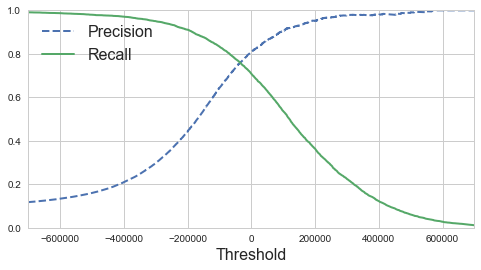

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])

plt.show()

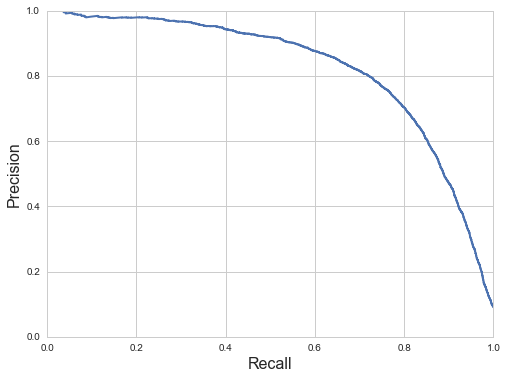

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

plt.show()

두 그래프를 보고 임계값을 확인... 정확한 수치는 어떻게 얻을 수 있을까?

In [32]:
y_train_pred_90 = (y_scores > 0)

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.8076114381833474

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.7085408596199964

**Note:**  
* 누군가가 '99%의 정밀도를 달성하자'라고 말한다면 반드시 '재현율 얼마에서?'라고 물어봐야 한다.

### 3.4 ROC 커브

거짓양성비율(False positive rate, FPR)에 대한 진짜 양성 비율(True Positive Rate, TPR)의 곡선  
임계값(threshold)의 변화에 따른 FPR과 Recall의 변화를 시각화  
  : 임계값이 달라진다면 판별 결과가 어떻게 달라지는지를 표현


* FPR (= Fall-Out / 위양성율)  
FPR = $\frac{FP}{FP+TN}=1-\frac{TN}{FP+TN} = 1-TNR$  

* Specificity(특이도) = 1 - FPR

일반적으로 클래스 판별 기준이 변화함에 따라 Recall과 FPR은 같이 증가하거나 감소한다.  
FPR보다 Recall이 더 빠르게 증가하는 모형은 좋은 모형으로 생각할 수 있다.

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

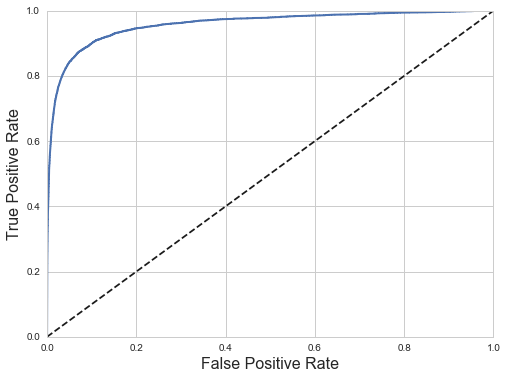

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

plt.show()

In [37]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9576836000640396

**Note:**  
* 곡선아래의 면적(AUC)을 측정하면 모델의 성능을 비교할 수 있다.
* 완벽한 분류기는 AUC가 1이고, 완전한 랜덤 분류기는 0.5이다.

* ROC곡선과 PR곡선 사용 기준  
  : 양성클래스가 드물거나 거짓음성보다 거짓 양성이 더 중요할때 PR곡선을 사용

In [38]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [39]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

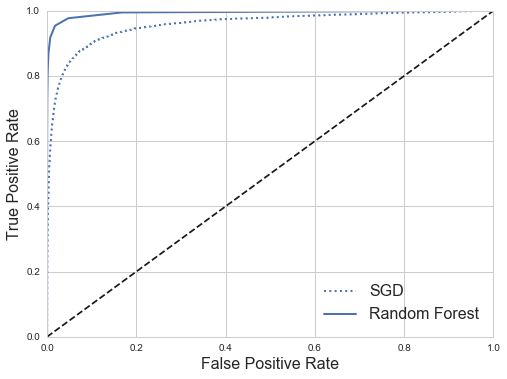

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931398719947719

In [42]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print("정밀도 : %.3f" % precision_score(y_train_5, y_train_pred_forest))
print("재현율 : %.3f" % recall_score(y_train_5, y_train_pred_forest))

정밀도 : 0.983
재현율 : 0.814


## 3.4 다중분류

* **OvO (One-Versus-One)**  
  : 0과1 구별, 0과2 구별 등과 같이 이진분류로 조합가능한 모든 분류기를 만들어서 훈련  
    클래스가 N 개라면,  $_{n}C_{2} = \frac{N!}{2!(N-2)!} = \frac{N \times (N-1)}{2}$


* **OvA (One-Versus-All) = OvR(One-Versus-the rest)**  
  : 각각의 클래스에 대해 표본이 속하는지 않는지 이진 분류로 풀고  
    결정 점수가 높은 클래스를 선택

In [43]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

**Note:**
* 5만 구별하는 분류 대신 0~9까지 구별할 수 있도록 훈련  
  10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 가장 높은 점수의 클래스를 선택

In [44]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-273776.50623306, -424091.92730101, -578010.43375341,
        -178200.8313653 , -383010.17742846,  -33489.33445771,
        -692650.91014638, -225981.42221558, -620104.9553446 ,
        -807184.29454182]])

In [45]:
np.argmax(some_digit_scores)

5

In [46]:
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
5.0


**Note:**  
* Classification은 훈련될 때 Classes_ 속성에 타깃 클래스의 값을 리스트로 정렬하여 저장

In [47]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [48]:
len(ovo_clf.estimators_)

45

**Note:**  
* OvO를 사용하게 되면, 이미지 1개를 분류하기 위해 45개의 분류기를 통과시켜서 훈련해야 한다.
  $\frac{10\times(10-1)}{2} = 45$

In [49]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [50]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.82373525, 0.87129356, 0.8419763 ])

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90806839, 0.91219561, 0.91208681])

## 3.5 에러분석

좋은 모델을 하나 선택했고, 이 모델의 성능을 향상 시킬 방법을 찾아보자!!

In [53]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5731,    3,   25,   11,   11,   49,   43,    9,   36,    5],
       [   1, 6466,   47,   32,    6,   38,    9,    9,  121,   13],
       [  54,   37, 5326,  110,   67,   24,   97,   60,  166,   17],
       [  51,   36,  139, 5334,    3,  236,   34,   53,  143,  102],
       [  19,   26,   37,    9, 5383,    8,   59,   26,   88,  187],
       [  73,   46,   35,  181,   77, 4593,  109,   30,  184,   93],
       [  30,   25,   47,    2,   42,   83, 5639,    6,   44,    0],
       [  19,   24,   73,   32,   52,   10,    6, 5803,   17,  229],
       [  58,  147,   66,  144,   14,  145,   59,   25, 5070,  123],
       [  41,   33,   28,   85,  163,   34,    2,  180,   81, 5302]])

In [54]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

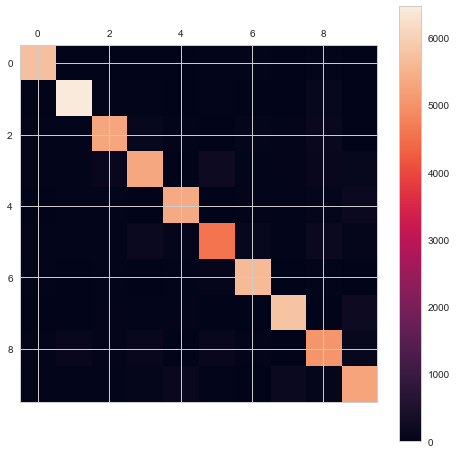

In [55]:
plot_confusion_matrix(conf_mx)
plt.show()

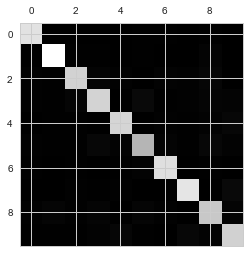

In [56]:
# 흑백버전
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

**Note:**  
* 주대각선을 보면 이미지가 올바르게 분류되고 있음을 알 수 있다.  
  특히 1을 잘 분류하고 5와 8은 조금 어둔운 것을 볼 수 있다.
  
  
* 숫자 5가 잘 분류되지 않는 다는 것은  
  숫자 5 이미지 수가 적거나, 숫자 5를 잘 분류하지 못한다는 뜻

In [57]:
row_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sum

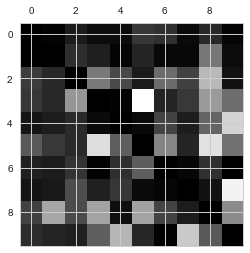

In [58]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

**Note:**  
* 행은 실제 클래스를 나타내고, 열은 예측한 클래스  
  클래스 8과 9의 행도 밝으므로 숫자 8과 9가 다른 숫자들과 혼돈이 자주 된다는 것
* 3과 5가 서로 혼돈

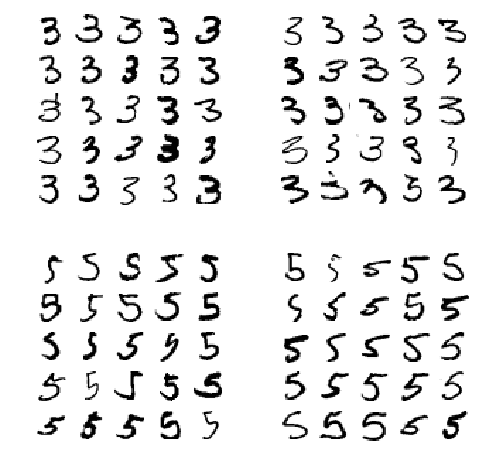

In [59]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

## 3.6 Multilabel Classification

다중 레이블 분류를 지원하는 모델은  
Decision Tree, Random Forest, OvRClassifier, KNeighborsClassifier

In [60]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [61]:
knn_clf.predict([some_digit])

array([[False,  True]])

### 3.6.1 다중 레이블 평가

average parameter에서 'macro'(평균), 'micro'(총합), 'weighted'(가중치)를 통해 F1 Score를 다르게 계산할 수 있다.

In [62]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9770193337255261

## 3.7 다중 출력 분류

다중출력/다중클래스 : 한 레이블이 여러개의 클래스를 가질 수 있는 것(정답이 2개 이상이 가능)